In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing lib
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Dict, Iterable
from datetime import datetime, timedelta

In [ ]:
TIME_STEP_INTERVAL = timedelta(hours=1) # creting an interval of 1 hour

def to_unix_time(timestamp: datetime) -> int:
    return time.mktime(timestamp.timetuple()) # convert local time to seconds since the Epoch

def with_fixed_time_steps(input_data: Dict[str, np.ndarray]) -> pd.DataFrame:
    return (
        pd.DataFrame(input_data)
        .assign(timestamp=lambda df: df["timestamp"].map(datetime.utcfromtimestamp))
        .resample(TIME_STEP_INTERVAL, on="timestamp")
        .mean()
        .reset_index()
        .assign(timestamp=lambda df: df["timestamp"].map(to_unix_time))
        .interpolate()
    )

In [ ]:
def read_data(data_file: str) -> pd.DataFrame:
    mmsi = os.path.splitext(os.path.basename(data_file))[0]
    with tf.io.gfile.GFile(data_file, "rb") as f:
        return with_fixed_time_steps(np.load(f)["x"]).assign(
            mmsi=lambda df: df["mmsi"].map(lambda _: int(mmsi)),
        )

In [ ]:
def read_labels(labels_file: str) -> pd.DataFrame:
    with tf.io.gfile.GFile(labels_file, "r") as f:
        return (
            pd.read_csv(f, parse_dates=["start_time", "end_time"])
            .assign(
                start_time=lambda df: df["start_time"].map(to_unix_time),
                end_time=lambda df: df["end_time"].map(to_unix_time),
            )
        )

In [ ]:
def label_data(data: pd.DataFrame, labels: pd.DataFrame) -> pd.DataFrame:
    data_with_labels = (
        pd.merge_asof(
            left=data,
            right=labels,
            left_on="timestamp",
            right_on="start_time",
            by="mmsi",
        )
        .query("timestamp <= end_time")
        .drop(columns=["start_time", "end_time"])
    )

    labeled_data = data.assign(is_fishing=lambda _: np.nan)
    labeled_data.update(data_with_labels)
    return labeled_data.sort_values(by=['timestamp']).drop(
        columns=["mmsi","distance_from_shore"]
    )

In [ ]:
data = read_data("/content/drive/MyDrive/fishing data/175387414441613.npz") # reading ship(175387414441613) route dataset
data.head()

,timestamp,mmsi,distance_from_shore,distance_from_port,speed,course,lat,lon
0,1.325437e+09,175387414441613,0.000000,999.975464,0.000000,201.699997,62.117252,-6.725497
1,1.325441e+09,175387414441613,2794.744466,4158.785290,0.026042,203.224997,62.099120,-6.710331
2,1.325444e+09,175387414441613,5589.488932,7317.595116,0.052083,204.749997,62.080987,-6.695165
3,1.325448e+09,175387414441613,8384.233398,10476.404942,0.078125,206.274997,62.062855,-6.679999
4,1.325452e+09,175387414441613,11178.977865,13635.214767,0.104167,207.799997,62.044722,-6.664834


In [ ]:
labels = read_labels("/content/drive/MyDrive/fishing data/kristina_trawl.csv") # reading label dataset
labels = labels[labels.mmsi == 175387414441613] # creating a col with ship's Maritime Mobile Service Identity (mmsi)
labels.head()

,mmsi,start_time,end_time,is_fishing
0,175387414441613,1.293840e+09,1.293841e+09,1.0
1,175387414441613,1.293851e+09,1.293852e+09,1.0
2,175387414441613,1.293857e+09,1.293859e+09,1.0
3,175387414441613,1.293863e+09,1.293864e+09,1.0
4,175387414441613,1.293869e+09,1.293870e+09,1.0


In [ ]:
data = label_data(data,labels) # joining labels and route dataset
data = data[~data['is_fishing'].isna()] # dropping null row
data.head()

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing
85,1.325743e+09,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
93,1.325772e+09,294769.289272,2.421875,343.525006,60.430931,-5.315076,1.0
96,1.325783e+09,304245.718750,2.500000,348.100006,60.376534,-5.269578,1.0
104,1.325812e+09,306889.402525,2.473510,336.091176,60.354940,-5.312330,1.0
127,1.325894e+09,314489.993377,2.397351,301.565789,60.292858,-5.435242,1.0


In [ ]:
import datetime

In [ ]:
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')) # converting time col
data.head()

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing
85,2012-01-05 06:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
93,2012-01-05 14:00:00,294769.289272,2.421875,343.525006,60.430931,-5.315076,1.0
96,2012-01-05 17:00:00,304245.718750,2.500000,348.100006,60.376534,-5.269578,1.0
104,2012-01-06 01:00:00,306889.402525,2.473510,336.091176,60.354940,-5.312330,1.0
127,2012-01-07 00:00:00,314489.993377,2.397351,301.565789,60.292858,-5.435242,1.0


In [ ]:
# creating new dataset with intervals of 1 hour
print(f"number of rows before: {data.shape[0]}")
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data = data.resample('60min').mean()
data = data.interpolate(method='nearest')
data.reset_index(level=0, inplace=True)
print(f"number of rows after: {data.shape[0]}")

number of rows before: 3969
number of rows after: 32734


In [ ]:
data.head()

,timestamp,distance_from_port,speed,course,lat,lon,is_fishing
0,2012-01-05 06:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
1,2012-01-05 07:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
2,2012-01-05 08:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
3,2012-01-05 09:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
4,2012-01-05 10:00:00,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0


In [ ]:
data.drop("timestamp", axis=1, inplace=True) # dropping timestamp col
data.head()

,distance_from_port,speed,course,lat,lon,is_fishing
0,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
1,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
2,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
3,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0
4,269498.810665,2.213542,331.325005,60.575991,-5.436402,1.0


In [ ]:
n = data.groupby(['is_fishing']).size()
print(n)

is_fishing
0.0    23571
1.0     9163
dtype: int64


In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

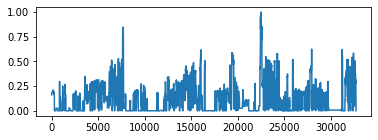

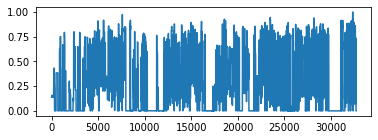

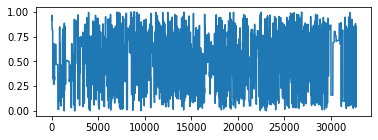

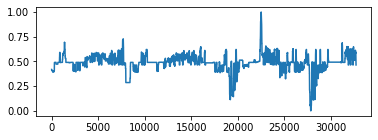

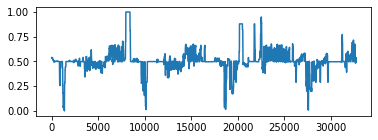

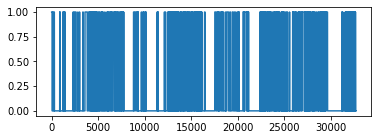

In [ ]:
for i in range(data.iloc[0,:].shape[0]):
    plt.figure(figsize=(6,2))
    plt.plot(NormalizeData(data.iloc[:,i]))
    plt.show()

In [ ]:
X=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

In [ ]:
X

array([[ 2.69498811e+05,  2.21354167e+00,  3.31325005e+02,
         6.05759909e+01, -5.43640243e+00],
       [ 2.69498811e+05,  2.21354167e+00,  3.31325005e+02,
         6.05759909e+01, -5.43640243e+00],
       [ 2.69498811e+05,  2.21354167e+00,  3.31325005e+02,
         6.05759909e+01, -5.43640243e+00],
       ...,
       [ 9.99975464e+02,  0.00000000e+00,  3.06200012e+02,
         6.15528078e+01, -6.80608761e+00],
       [ 9.99975464e+02,  0.00000000e+00,  3.06200012e+02,
         6.15528078e+01, -6.80608761e+00],
       [ 9.99975464e+02,  0.00000000e+00,  3.06200012e+02,
         6.15528078e+01, -6.80608761e+00]])

In [ ]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Predictive Accuracy achieved for Logistic Regression:',accuracy_score(y_test, y_pred)*100)

[[4290  414]
 [1036  807]]
Predictive Accuracy achieved for Logistic Regression: 77.85245150450588


#SVM

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Predictive Accuracy achieved for SVM:',accuracy_score(y_test, y_pred)*100)

[[3872  832]
 [ 481 1362]]
Predictive Accuracy achieved for SVM: 79.94501298304567


#KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Predictive Accuracy achieved for KNN:',accuracy_score(y_test, y_pred)*100)

[[4556  148]
 [ 134 1709]]
Predictive Accuracy achieved for KNN: 95.6926836719108


#Naive Bayes


In [ ]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Predictive Accuracy achieved for Naive Bayes:',accuracy_score(y_test, y_pred)*100)

[[4321  383]
 [1033  810]]
Predictive Accuracy achieved for Naive Bayes: 78.37177333129678


#XGBoost(Gradient Boosting)

In [ ]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(X_train, y_train)

XGBClassifier()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = xg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Predictive Accuracy achieved for XGBoost:',accuracy_score(y_test, y_pred)*100)

[[4438  266]
 [ 248 1595]]
Predictive Accuracy achieved for XGBoost: 92.14907591263174


#Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Predictive Accuracy achieved for Decision Tree:',accuracy_score(y_test, y_pred)*100)

[[4689   15]
 [  18 1825]]
Predictive Accuracy achieved for Decision Tree: 99.4959523445853


#RFC

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Predictive Accuracy achieved for RFC:',accuracy_score(y_test, y_pred)*100)

[[4696    8]
 [  10 1833]]
Predictive Accuracy achieved for RFC: 99.72506491522834


#Cross Validation using K-fold

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train)
print("Accuracy mean: {:.2f} %".format(accuracies.mean()*100))
print("Accuracy min: {:.2f} %".format(accuracies.min()*100))
print("Accuracy max: {:.2f} %".format(accuracies.max()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy mean: 78.20 %
Accuracy min: 77.40 %
Accuracy max: 78.60 %
Standard Deviation: 0.44 %


#Cross Validation using Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'var_smoothing': np.logspace(0,-9, num=100),
              'priors':[None]
              }
grid = GridSearchCV(estimator = classifier,param_grid = parameters,scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1
                           )
grid.fit(X_train, y_train)
best_accuracy = grid.best_score_
best_parameters = grid.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 78.23 %
Best Parameters: {'priors': None, 'var_smoothing': 1e-09}


In [ ]:
classifier.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [ ]:
dt.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [ ]:
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

#Visualization

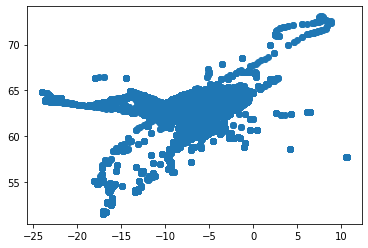

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=data['lon'], y=data['lat'])
plt.show()

In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


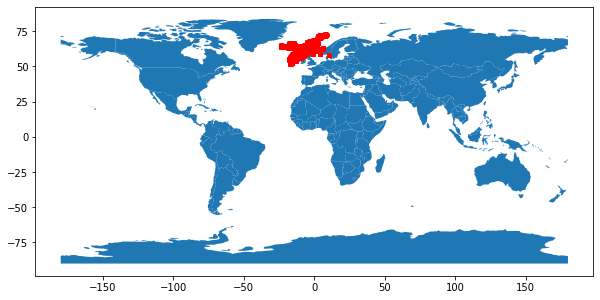

In [ ]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in zip(data['lon'], data['lat'])]
gdf = GeoDataFrame(data, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [ ]:
import plotly.express as px
import pandas as pd

fig = px.scatter_geo(data,lat='lat',lon='lon', hover_name="is_fishing")
fig.update_layout(title = '', title_x=0.5)
fig.show()

#Conclusion


1. We implemented the model using all the algorithms which were present in the syllabus being a classification problem we implemented the model using Logistic Regression, SVM, KNN, Naive Bayes, DT and RFC.
2. We observed that the predictive accuracy for some models were rather high than others, specifically for Decision tree and Random forest classifier the reason behind this was that our dataset was not very high dimensional(multiple features) and because of this reason the variance incresed(Algorithms like DT and RFC can make very complicated assumptions which are not preferable for low dimensional datasets) thereby causing  the model to overfit the data. The phenomenon of overfitting can be reduced by:-
a. Using less complicated alogorithms or alogorithms with fewer hyperparameters.
b. Removing noise/outliers from the training data.
c. Gathering more training data. 
3. Lastly we implemented Cross validation(Used for estimating test set performance of a model) methods like **k-fold**(splitting the data into k bins, using each bin as testing data and using rest of the data as training data.We validate the training data with the test data and repeat the process k times.Unless we get the average performance) and **Grid-search**(It is a method of selecting the best model taken into consideration a grid of parameters. Parameters of Naive Bayes like priors(Concerning the prior class probabilities, when priors are provided (in an array) they won’t be adjusted based on the dataset), var_smoothing(Concerning variance smoothing, float value provided will be used to calculate the largest variances of each feature and add it to the stability calculation variance).The best accuracy the we achieved using both the methods were **78.20 % and 78.23 %** respectively.